# Fake News through Stance Detection

## Problem

Using classification models to learn how to predict whether an article is Fake News using Stance Detection. Stance detection takes a headline and body text of an article and classifies the stance of the body text relative to headline. 

### Imports

In [1]:
#Loading libraries
import pandas as pd 

import os
import re
import nltk
from sklearn import feature_extraction
from tqdm import tqdm


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
bodies = pd.read_csv('./train_bodies.csv')
stances = pd.read_csv('./train_stances.csv')


## EDA

In [3]:
bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [4]:
stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
stances['Stance'].unique()

array(['unrelated', 'agree', 'disagree', 'discuss'], dtype=object)

4 Classes within the stances: unrelated, agree, disagree, and discuss. 

In [6]:
bodies.isnull().sum()

Body ID        0
articleBody    0
dtype: int64

In [7]:
stances.isnull().sum()

Headline    0
Body ID     0
Stance      0
dtype: int64

Checking for nulls within the datasets. 

In [8]:
bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
Body ID        1683 non-null int64
articleBody    1683 non-null object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [9]:
stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
Headline    49972 non-null object
Body ID     49972 non-null int64
Stance      49972 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Checking for types of data. 

In [10]:
print("Total stances: " + str(len(stances.Stance)))
print("Total article bodies: " + str(len(bodies.articleBody)))

Total stances: 49972
Total article bodies: 1683


In [11]:
stances[stances['Body ID'] == 712]

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1787,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss
3974,Mexico police find mass grave near site 43 stu...,712,unrelated
4936,Mexico Says Missing Students Not Found In Firs...,712,unrelated
5210,New iOS 8 bug can delete all of your iCloud do...,712,unrelated
5863,Return of the Mac: Seth Rogen in talks to star...,712,discuss
6199,Seth Rogen Is Woz,712,discuss
6756,Mexico finds 4 more graves at site of suspecte...,712,unrelated
7526,Are missing students in mass graves found near...,712,unrelated
9003,Mexico prosecutor: Students not in 1st mass gr...,712,unrelated


There are many more stances than there are article bodies. This means that there are many articles that are being used with different headlines. 

In [12]:
df_all = stances.merge(bodies, on = 'Body ID')
df_all.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...


Merging together the datasets on the Body ID. 

In [13]:
df_all.shape

(49972, 4)

## Baseline

In [14]:
stances['Stance'].value_counts(normalize=True)

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

Our baseline class is 0.731710. This is going to be the score we aim to do better than. 

In [ ]:
class_balance = stances['Stance'].value_counts(normalize=True)
sns.barplot(['Unrelated','Discuss', 'Agree', 'Disagree'], class_balance)
plt.ylabel('Articles')
plt.title('Stances');

# Natural Language Processing

## Count Vectorizer

Count vectorizer converts by text into a matrix of token counts. I recieve a sparse matrix from this which makes it easier to create a model. 

In [16]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

cvec_body = CountVectorizer(stop_words = 'english')

train_body_cvec = cvec_body.fit_transform(X_train['articleBody'])
test_body_cvec = cvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_cvec, y_train)
lr.score(test_body_cvec, y_test)

0.7320899703834147

In [17]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

cvec_headline= CountVectorizer(stop_words = 'english')

train_headline_cvec = cvec_headline.fit_transform(X_train['Headline'])
test_headline_cvec = cvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_cvec, y_train)
lr.score(test_headline_cvec, y_test)

0.7313495557512207

In [ ]:
combo = df_all[['Headline', 'articleBody']].copy(deep=True)

In [ ]:
#headline
X_train = combo
y_train = stances['Stance']
X_test = combo
y_test = stances['Stance']

cvec_headline= CountVectorizer(stop_words = 'english')

train_headline_cvec = cvec_headline.fit_transform(X_train[combo])
test_headline_cvec = cvec_headline.transform(X_test[combo])

lr = LogisticRegression()
lr.fit(train_headline_cvec, y_train)
lr.score(test_headline_cvec, y_test)

In [18]:
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

cvec_body = CountVectorizer(stop_words = 'english')

train_body_cvec = cvec_body.fit_transform(X_train['articleBody'])
test_body_cvec = cvec_body.transform(X_test['articleBody'])

rf = RandomForestClassifier()
rf.fit(train_body_cvec, y_train)
rf.score(test_body_cvec, y_test)

0.7319699031457616

In [19]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

cvec_headline= CountVectorizer(stop_words = 'english')

train_headline_cvec = cvec_headline.fit_transform(X_train['Headline'])
test_headline_cvec = cvec_headline.transform(X_test['Headline'])

rf = RandomForestClassifier()
rf.fit(train_headline_cvec, y_train)
rf.score(test_headline_cvec, y_test)

0.7312895221323942

After using CountVectorizer on the article Body and stances we find that our scores improves a little using Logistic Regression. 
Our baseline is 0.731710 while CountVectorizer brought us to 0.73201. When using CountVectorizer on the Headlines, our score is performing worse than baseline at 0.731349. 

# Hashing Vectorizer

The hashing vectorizer coverts the text and returns a matrix of token occurences. 

In [20]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

hvec_body = HashingVectorizer(stop_words = 'english')

train_body_hvec = hvec_body.fit_transform(X_train['articleBody'])
test_body_hvec = hvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_hvec, y_train)
lr.score(test_body_hvec, y_test)

0.7313095333386697

In [21]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

hvec_headline = HashingVectorizer(stop_words = 'english')

train_headline_hvec = hvec_headline.fit_transform(X_train['Headline'])
test_headline_hvec = hvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_hvec, y_train)
lr.score(test_headline_hvec, y_test)

0.7313095333386697

In [ ]:
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

hvec_body = HashingVectorizer(stop_words = 'english')

train_body_hvec = hvec_body.fit_transform(X_train['articleBody'])
test_body_hvec = hvec_body.transform(X_test['articleBody'])

rf = RandomForestClassifier()
rf.fit(train_body_hvec, y_train)
rf.score(test_body_hvec, y_test)

In [ ]:
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

hvec_headline = HashingVectorizer(stop_words = 'english')

train_headline_hvec = hvec_headline.fit_transform(X_train['Headline'])
test_headline_hvec = hvec_headline.transform(X_test['Headline'])

rf = RandomForestClassifier()
rf.fit(train_headline_hvec, y_train)
rf.score(test_headline_hvec, y_test)

After using HashingVectorizer on the article Body and stances we find that our score does not improve using Logistic Regression. 
Our baseline is 0.731710 while HashingVectorizer brought us to 0.73131. When using HashingVectorizer on the Headlines, our score is performing worse than baseline at 0.73131. 

# TF IDF 

TF IDF returns my text as a matrix of TF IDF features. TF IDF is a statistic that is intended to reflect how important a word is to a document in a collection of texts. Since this one is more statistically related it is projected to give the best score.

In [22]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

tvec_body = TfidfVectorizer(stop_words = 'english')

train_body_tvec = tvec_body.fit_transform(X_train['articleBody'])
test_body_tvec = tvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_tvec, y_train)
lr.score(test_body_tvec, y_test)

0.7313095333386697

In [23]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

tvec_headline = TfidfVectorizer(stop_words = 'english')

train_headline_tvec = tvec_headline.fit_transform(X_train['Headline'])
test_headline_tvec = tvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_tvec, y_train)
lr.score(test_headline_tvec, y_test)

0.7313095333386697

In [24]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

tvec_body = TfidfVectorizer(stop_words = 'english')

train_body_tvec = tvec_body.fit_transform(X_train['articleBody'])
test_body_tvec = tvec_body.transform(X_test['articleBody'])

rf = RandomForestClassifier()
rf.fit(train_body_cvec, y_train)
rf.score(test_body_cvec, y_test)

0.7319498919394861

In [25]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

tvec_headline = TfidfVectorizer(stop_words = 'english')

train_headline_tvec = tvec_headline.fit_transform(X_train['Headline'])
test_headline_tvec = tvec_headline.transform(X_test['Headline'])

rf = RandomForestClassifier()
rf.fit(train_headline_cvec, y_train)
rf.score(test_headline_cvec, y_test)

0.7313495557512207

After using TF IDF(term frequency-inverse document frequency) on the article Body and stances we find that our score does not improve using Logistic Regression. 
Our baseline is 0.73171 while TF IDF brought us to 0.731309. When using TF IDF on the Headlines, our score is performing at 0.731309.  
    

## Preprocessing for latent Dirichlet allocation

Since none of the word processing vectorizers proved to be fruitful in helping improve above baseline, I will be now applying some processing on the text and fit new models. LDA is a statistical model that helps to show why some groups of data are similar. 

In [26]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # stemming
    #porter_stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    text_processed = [wordnet_lemmatizer.lemmatize(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed ## <-- we're keeping our words distinct

In [27]:
df_all['articleBody'] = df_all['articleBody'].apply(text_process)

In [28]:
df_all['articleBody'].head()

0    [danny, boyle, directing, untitled, film, seth...
1    [danny, boyle, directing, untitled, film, seth...
2    [danny, boyle, directing, untitled, film, seth...
3    [danny, boyle, directing, untitled, film, seth...
4    [danny, boyle, directing, untitled, film, seth...
Name: articleBody, dtype: object

In [29]:
df_all['Headline'] = df_all['Headline'].apply(text_process)

In [30]:
df_all['Headline'].head()

0    [police, find, mass, graf, least, 15, body, ne...
1           [seth, rogen, play, apple, steve, wozniak]
2    [mexico, police, find, mass, grave, near, site...
3    [mexico, say, missing, student, found, first, ...
4          [new, io, 8, bug, delete, icloud, document]
Name: Headline, dtype: object

## Fit LDA Model

In [31]:
from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

np.random.seed(42)

## latent Dirichlet allocation on Article Body

Visualizing the similarities between topics in the article bodies. 

In [32]:
dictionary = corpora.Dictionary(df_all['articleBody'])

corpus = [dictionary.doc2bow(text) for text in df_all['articleBody']]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 20,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [33]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
17     8.472813        1       1 -0.226878 -0.019111
9      7.594972        1       2  0.112293 -0.000422
2      7.311625        1       3  0.083541 -0.021568
13     6.791107        1       4  0.108506  0.080758
8      6.466279        1       5 -0.174058 -0.042057
7      5.406447        1       6  0.187085 -0.060071
14     5.100556        1       7 -0.112053  0.049267
3      4.986382        1       8 -0.218530 -0.084039
12     4.938644        1       9  0.117558  0.017824
6      4.882309        1      10 -0.059652 -0.100930
0      4.623836        1      11 -0.111733 -0.080454
19     4.126402        1      12  0.143796 -0.016094
1      4.123351        1      13 -0.024209  0.294692
18     4.007891        1      14  0.105916  0.023174
5      3.879489        1      15  0.103317 -0.141876
4      3.818942        1      16  0.013767  0.042428
16     3.808361        1      17  0.129776 -0.044188
10     3.591948        1      18  0.102500 -0.032545
11     3.399814        1      19 -0.109929  0.261608
15     2.668834        1      20 -0.171014 -0.126397, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
6     Default   44045.000000         apple   44045.000000  30.0000  30.0000
1574  Default   30442.000000         watch   30442.000000  29.0000  29.0000
2527  Default   22237.000000           kim   22237.000000  28.0000  28.0000
97    Default   28784.000000            al   28784.000000  27.0000  27.0000
1218  Default   46117.000000         video   46117.000000  26.0000  26.0000
818   Default   34001.000000           isi   34001.000000  25.0000  25.0000
861   Default   20626.000000         north   20626.000000  24.0000  24.0000
353   Default   24473.000000        police   24473.000000  23.0000  23.0000
1180  Default   16882.000000         foley   16882.000000  22.0000  22.0000
363   Default   17942.000000          shot   17942.000000  21.0000  21.0000
3992  Default   13910.000000         brown   13910.000000  20.0000  20.0000
210   Default  130181.000000          said  130181.000000  19.0000  19.0000
343   Default   26540.000000       islamic   26540.000000  18.0000  18.0000
914   Default   41793.000000         state   41793.000000  17.0000  17.0000
107   Default   17448.000000        border   17448.000000  16.0000  16.0000
2895  Default   10801.000000         ebola   10801.000000  15.0000  15.0000
944   Default   47036.000000             u   47036.000000  14.0000  14.0000
2644  Default   12495.000000          jong   12495.000000  13.0000  13.0000
1215  Default   22614.000000         syria   22614.000000  12.0000  12.0000
563   Default   20635.000000      american   20635.000000  11.0000  11.0000
296   Default   29728.000000           man   29728.000000  10.0000  10.0000
816   Default   19260.000000          iraq   19260.000000   9.0000   9.0000
279   Default   16631.000000          girl   16631.000000   8.0000   8.0000
803   Default   33140.000000         group   33140.000000   7.0000   7.0000
1621  Default   13616.000000       officer   13616.000000   6.0000   6.0000
1785  Default   10156.000000         haram   10156.000000   5.0000   5.0000
1737  Default   10093.000000          boko   10093.000000   4.0000   4.0000
2649  Default   10183.000000         korea   10183.000000   3.0000   3.0000
43    Default   11492.000000           job   11492.000000   2.0000   2.0000
240   Default   10498.000000            un   10498.000000   1.0000   1.0000
...       ...            ...           ...            ...      ...      ...
8168  Topic20     478.526062       malaria     479.476471   3.6215  -6.4029
3573  Topic20     594.338135        frisco     595.912964   3.6209  -6.1861
1075  Topic20    4736.602539        banksy    4924.308594   3.5847  -4.1105
2227  Topic20    1919.205444        artist    1968.9881

## latent Dirichlet allocation on Headline

Visualizing the similarities between topics in the Headlines. 

In [34]:
dictionary = corpora.Dictionary(list(df_all['Headline']))

corpus = [dictionary.doc2bow(text) for text in df_all['Headline']]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 20,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [35]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
7      7.175739        1       1  0.160565 -0.236766
15     6.986013        1       2 -0.055301  0.092987
9      6.434521        1       3 -0.047171  0.080033
6      6.159083        1       4  0.033375 -0.118654
5      5.968647        1       5  0.172359  0.133394
19     5.822701        1       6  0.031229  0.184130
13     5.576653        1       7  0.031246 -0.039357
12     5.277154        1       8  0.190933  0.063809
16     4.846416        1       9 -0.262180  0.068002
11     4.759069        1      10  0.150684  0.096401
10     4.680370        1      11 -0.265636  0.023132
0      4.676740        1      12 -0.080662  0.049703
14     4.424639        1      13  0.220810 -0.044855
2      4.332467        1      14 -0.112297 -0.026703
4      4.281420        1      15 -0.079351 -0.041128
8      4.159107        1      16 -0.078881 -0.186555
3      3.989267        1      17  0.038145 -0.165177
18     3.813822        1      18  0.042447  0.220686
1      3.670227        1      19 -0.152054 -0.093390
17     2.965941        1      20  0.061741 -0.059691, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
221   Default  2875.000000       state  2875.000000  30.0000  30.0000
69    Default  6749.000000         isi  6749.000000  29.0000  29.0000
436   Default  2292.000000         kim  2292.000000  28.0000  28.0000
217   Default  2870.000000     islamic  2870.000000  27.0000  27.0000
14    Default  2829.000000       apple  2829.000000  26.0000  26.0000
430   Default  2661.000000       foley  2661.000000  25.0000  25.0000
435   Default  2099.000000        jong  2099.000000  24.0000  24.0000
73    Default  3714.000000           u  3714.000000  23.0000  23.0000
18    Default  1731.000000       steve  1731.000000  22.0000  22.0000
431   Default  2402.000000       james  2402.000000  21.0000  21.0000
468   Default  1844.000000       haram  1844.000000  20.0000  20.0000
465   Default  1844.000000        boko  1844.000000  19.0000  19.0000
37    Default  1624.000000         job  1624.000000  18.0000  18.0000
437   Default  1779.000000          un  1779.000000  17.0000  17.0000
94    Default  2009.000000      leader  2009.000000  16.0000  16.0000
80    Default  2329.000000       watch  2329.000000  15.0000  15.0000
505   Default  1652.000000       brown  1652.000000  14.0000  14.0000
432   Default  2153.000000  journalist  2153.000000  13.0000  13.0000
504   Default  1580.000000       audio  1580.000000  12.0000  12.0000
56    Default  2210.000000     michael  2210.000000  11.0000  11.0000
452   Default  2631.000000       video  2631.000000  10.0000  10.0000
428   Default  1920.000000    american  1920.000000   9.0000   9.0000
467   Default  1490.000000        girl  1490.000000   8.0000   8.0000
98    Default  1155.000000   christian  1155.000000   7.0000   7.0000
97    Default  1155.000000        bale  1155.000000   6.0000   6.0000
15    Default  1193.000000        play  1193.000000   5.0000   5.0000
486   Default  1056.000000          al  1056.000000   4.0000   4.0000
180   Default  1605.000000    militant  1605.000000   3.0000   3.0000
506   Default  1395.000000    shooting  1395.000000   2.0000   2.0000
12    Default  1026.000000     student  1026.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1235  Topic20    54.135845      agrees    55.081535   3.5007  -5.4582
1519  Topic20    53.068871        pack    54.014561   3.5003  -5.4781
1515  Topic20    53.068871        brat    54.014561   3.5003  -5.4781
1041  Topic20    52.950623   cawthorne    53.896313   3.5003  -5.4804
1105  Topic20    47.330612      briton    48.276302   3.4982  -5.5926
1987  Topic20    46.501282      timing    47.446972   3.4978  -5.6102
1988  Topic20    46.501282    verifies    47.446972   3.4978 

## preprocessing for Latent Semantic Analysis

 More processing before applying vectorizers. Latent semantic analysis is another technique used to analyze the relationships between the documents and the terms in them.

In [36]:
import re

In [37]:
def cleaner(text):
    text = re.sub('&#39;','',text).lower()
    text = re.sub('<br />','',text)
    text = re.sub('<.*>.*</.*>','', text)
    text = re.sub('\\ufeff', '', text)
    text = re.sub('[\d]','',text)
    text = re.sub('[^a-z ]','',text)
    
    return text

<input>:6: DeprecationWarning: invalid escape sequence \d
<input>:6: DeprecationWarning: invalid escape sequence \d
<input>:6: DeprecationWarning: invalid escape sequence \d
<ipython-input-37-6de38bea8180>:6: DeprecationWarning: invalid escape sequence \d
  text = re.sub('[\d]','',text)


In [38]:
df_all['articleBody'] = df_all['articleBody'].map(str)
df_all['articleBody'] = df_all['articleBody'].apply(cleaner)

In [39]:
df_all['articleBody'].iloc[1]

'danny boyle directing untitled film seth rogen eyed play apple co founder steve wozniak sony steve job biopic danny boyle directing untitled film based walter isaacson book adapted aaron sorkin one anticipated biopics recent year negotiation yet begun even clear rogen official offer producer scott rudin guymon casady mark gordon set sight talent talk course may naught christian bale actor play job still midst closing deal source say dealmaking process sensitive stage insider say boyle flying los angeles meet actress play one female lead assistant job insider say jessica chastain one actress meeting list wozniak known woz co founded apple job ronald wayne first met job worked atari later responsible creating early apple computer'

In [40]:
df_all['Headline'] = df_all['Headline'].map(str)
df_all['Headline'] = df_all['Headline'].apply(cleaner)

### Saving work to CSV 

In [41]:
df_all.to_csv('./preprocessed.csv')

In [42]:
df_all = pd.read_csv('../preprocessed.csv')

### tfidf vectorizer

Using TF IDF vectorizer to turn into sparse matrices after preprocessing then convert the matrices into dataframes.  

In [43]:
tfidf_vector = TfidfVectorizer(min_df = 5, stop_words='english')

articleBody_matrix_sparse = tfidf_vector.fit_transform(df_all['articleBody'])
articleBody_matrix_sparse

<49972x18408 sparse matrix of type '<class 'numpy.float64'>'
	with 6480420 stored elements in Compressed Sparse Row format>

In [44]:
articleBody_df_tfdf = pd.DataFrame(articleBody_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [45]:
articleBody_df_tfdf.head()

,aafia,aamaq,aamir,aan,aapl,aaron,aback,abadam,abadi,abagnale,...,zobl,zone,zoning,zoology,zor,zubayr,zubeyr,zuckerberg,zulu,zxycaeuwb
0,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
headline_matrix_sparse = tfidf_vector.fit_transform(df_all['Headline'])
headline_matrix_sparse

<49972x2736 sparse matrix of type '<class 'numpy.float64'>'
	with 388147 stored elements in Compressed Sparse Row format>

In [47]:
headline_df_tfdf = pd.DataFrame(headline_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [48]:
headline_df_tfdf.head()

,aaron,abandoned,abdel,abdi,abducted,abducting,abdul,abdullah,abort,aborted,...,younger,youngest,youtube,ypg,yum,zack,zehaf,zeppelin,zero,zhejiang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Truncated SVD

We now need to  perform linear dimensionality reduction using singular value decomposition on the TF IDF matrices. We need the matrices in this form to calculate cosine similarity. 

In [49]:
from sklearn.decomposition import TruncatedSVD

In [50]:
n_components = 100
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i) for i in range(n_components)]

In [51]:
articleBody_svd_matrix = SVD.fit_transform(articleBody_df_tfdf)
articleBody_svd_matrix

array([[ 0.09533842,  0.20917657, -0.02623447, ..., -0.01842468,
        -0.01329635,  0.00160345],
       [ 0.09533842,  0.20917657, -0.02623447, ..., -0.01842468,
        -0.01329635,  0.00160345],
       [ 0.09533842,  0.20917657, -0.02623447, ..., -0.01842468,
        -0.01329635,  0.00160345],
       ...,
       [ 0.10926743, -0.00405857, -0.01237433, ..., -0.0078137 ,
         0.01992944, -0.00284108],
       [ 0.17433645,  0.51243759, -0.07441561, ..., -0.03089425,
        -0.01542923, -0.01088547],
       [ 0.16292306,  0.66241464, -0.1288089 , ..., -0.0098862 ,
        -0.01244625, -0.02435808]])

In [52]:
headline_svd_matrix = SVD.fit_transform(headline_df_tfdf)
headline_svd_matrix

array([[ 0.01147472,  0.00935667,  0.00474699, ...,  0.05792497,
        -0.06416471,  0.0664541 ],
       [ 0.00723122,  0.05075079, -0.00227505, ...,  0.01528682,
        -0.02149199,  0.00855633],
       [ 0.01427154,  0.00729155,  0.00614716, ...,  0.05510026,
        -0.05917941,  0.0499812 ],
       ...,
       [ 0.01233532,  0.00230594,  0.00526008, ..., -0.00503097,
        -0.029953  ,  0.02016431],
       [ 0.01735207,  0.01500696,  0.00583619, ..., -0.01005641,
         0.00682132, -0.00083453],
       [ 0.00979547,  0.01030194,  0.00912457, ..., -0.01906919,
         0.03719339, -0.0674999 ]])

In [53]:
articleBody_svd_matrix.shape

(49972, 100)

## Cosine Similarity

Calculate distances between headline and articles to use as our X. 

In [54]:
import scipy.spatial as sp

In [55]:
distances = []
for i, body in enumerate(articleBody_svd_matrix): 
    distances.append(sp.distance.cdist([body], [headline_svd_matrix[i]], 'cosine')[0][0])

In [56]:
df_all['distances'] = pd.Series(distances)

In [57]:
df_all.shape

(49972, 6)

### Eliminating Nulls from all Data

In [58]:
df_all.shape

(49972, 6)

In [59]:
df_all = df_all.dropna(axis=0)

In [60]:
df_all.shape

(49970, 6)

In [61]:
df_all.head()

,Unnamed: 0,Headline,Body ID,Stance,articleBody,distances
0,0,police find mass graf least body near mexico ...,712,unrelated,danny boyle directing untitled film seth rogen...,0.852089
1,1,seth rogen play apple steve wozniak,712,discuss,danny boyle directing untitled film seth rogen...,0.952722
2,2,mexico police find mass grave near site stude...,712,unrelated,danny boyle directing untitled film seth rogen...,0.834662
3,3,mexico say missing student found first mass graf,712,unrelated,danny boyle directing untitled film seth rogen...,0.766238
4,4,new io bug delete icloud document,712,unrelated,danny boyle directing untitled film seth rogen...,0.965413


### Adding labels to stances

In [62]:
from sklearn import preprocessing

In [63]:
le = preprocessing.LabelEncoder()
le.fit(df_all['Stance'])
print("Classes:", list(le.classes_))
stance_label = le.transform(df_all['Stance']) 


Classes: ['agree', 'disagree', 'discuss', 'unrelated']


In [64]:
stance_label

array([3, 2, 3, ..., 0, 2, 2])

Creating dummies for the four stances. 

In [65]:
df_all['stance_dummy'] = pd.Series(stance_label)

In [66]:
df_all.head()

,Unnamed: 0,Headline,Body ID,Stance,articleBody,distances,stance_dummy
0,0,police find mass graf least body near mexico ...,712,unrelated,danny boyle directing untitled film seth rogen...,0.852089,3.0
1,1,seth rogen play apple steve wozniak,712,discuss,danny boyle directing untitled film seth rogen...,0.952722,2.0
2,2,mexico police find mass grave near site stude...,712,unrelated,danny boyle directing untitled film seth rogen...,0.834662,3.0
3,3,mexico say missing student found first mass graf,712,unrelated,danny boyle directing untitled film seth rogen...,0.766238,3.0
4,4,new io bug delete icloud document,712,unrelated,danny boyle directing untitled film seth rogen...,0.965413,3.0


In [67]:
stance_dummy = pd.get_dummies(df_all['Stance'], drop_first=False)
stance_dummy.head()

,agree,disagree,discuss,unrelated
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


Join both distances and stance dummy in one data frame for easy access and drop nulls if any. 

In [68]:
df_fix = pd.DataFrame([df_all['distances'], df_all['stance_dummy']]).T
df_fix = df_fix.dropna(axis=0)
df_fix.head()

,distances,stance_dummy
0,0.852089,3.0
1,0.952722,2.0
2,0.834662,3.0
3,0.766238,3.0
4,0.965413,3.0


In [69]:
df_fix.shape

(49968, 2)

## Model with Distance

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X = df_fix['distances'].reshape(df_fix['distances'].shape[0], 1)
y = df_fix['stance_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y)

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37476, 1), (12492, 1), (37476,), (12492,))

In [73]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7323086775536344

In [74]:
lr.score(X_test, y_test)

0.7280659622158181

In [75]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9554114633365354

In [76]:
rf.score(X_test, y_test)

0.6004642971501761

After calculating cosine similarity between the headline and article body matrices the logistic regression model performed at 0.73156 compared to our baseline of 0.73171. Random forest scored very well but I found it was very overfit after scoring on the test. 
    

## Reciever Operating Characteristic (ROC) Curve

In [77]:
from sklearn.metrics import roc_auc_score

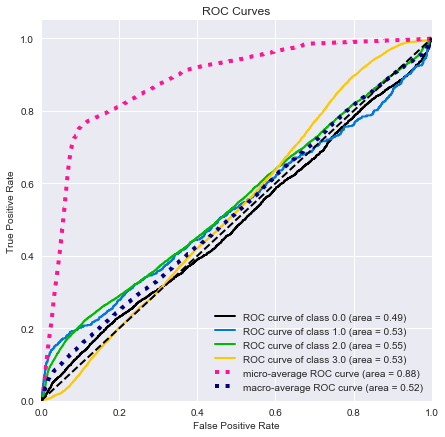

In [78]:
y_probas = lr.predict_proba(X_train)
y_true = y_train

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_true, y_probas, figsize=(7,7))
plt.show()

In [79]:
y_true.unique(), y_true.shape

(array([3., 2., 0., 1.]), (37476,))

In [80]:
np.unique(y_probas), y_probas.shape

(array([0.01239605, 0.01248264, 0.01250638, ..., 0.83854244, 0.83973123,
        0.84167663]), (37476, 4))

In [81]:
y_probas

array([[0.07404778, 0.01641419, 0.21848308, 0.69105494],
       [0.07333306, 0.01752318, 0.16576292, 0.74338084],
       [0.07360288, 0.01717247, 0.18144904, 0.72777562],
       ...,
       [0.07419468, 0.01603326, 0.23857131, 0.67120075],
       [0.07364581, 0.01711153, 0.18427031, 0.72497235],
       [0.07365049, 0.01710479, 0.18458415, 0.72466057]])

The curve plots the diagnostic ability for the classifier system. The ROC curve plots the sensitivity against the false positive rate at various thresholds. A macro average will give us a score for each class then take the average. A mirco average will aggregate the contributoins of each class to give the average metric. The micro average shows us there is still a possibility for us to reach this number!

## Over Sampling 

Trying to adjust the class distribution. 

In [82]:
from imblearn.over_sampling import RandomOverSampler

In [83]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0.0, 36542), (1.0, 36542), (2.0, 36542), (3.0, 36542)]


In [84]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
lr.score(X_resampled, y_resampled)

0.2672814843194133

# Model with count vectorized body, count vectorized head, and distances

I count vectorize both headline and body. 

In [85]:
cvec_vector = CountVectorizer(stop_words='english')
cvec_articleBody_matrix_sparse = cvec_vector.fit_transform(df_all['articleBody'])
cvec_articleBody_matrix_sparse

<49970x19665 sparse matrix of type '<class 'numpy.int64'>'
	with 6483114 stored elements in Compressed Sparse Row format>

In [86]:
cvec_body_array = cvec_articleBody_matrix_sparse.toarray()

In [87]:
df_cvec = pd.DataFrame(cvec_body_array)

In [88]:
df_cvec.head()

,0,1,2,3,4,5,6,7,8,9,...,19655,19656,19657,19658,19659,19660,19661,19662,19663,19664
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
cvec_vector = CountVectorizer(stop_words='english')
cvec_headline_matrix_sparse = cvec_vector.fit_transform(df_all['Headline'])
cvec_headline_matrix_sparse

<49970x2800 sparse matrix of type '<class 'numpy.int64'>'
	with 388345 stored elements in Compressed Sparse Row format>

In [90]:
cvec_vector.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [91]:
cvec_headline_df = pd.DataFrame(cvec_headline_matrix_sparse.todense(),
                       columns = cvec_vector.get_feature_names())

In [92]:
cvec_headline_df.shape

(49970, 2800)

In [93]:
cvec_vector = CountVectorizer(stop_words='english')

cvec_articlebody_matrix_sparse = cvec_vector.fit_transform(df_all['articleBody'])

cvec_articlebody_matrix_sparse

<49970x19665 sparse matrix of type '<class 'numpy.int64'>'
	with 6483114 stored elements in Compressed Sparse Row format>

In [94]:
cvec_articlebody_df = pd.DataFrame(cvec_articlebody_matrix_sparse.todense(),
                       columns = cvec_vector.get_feature_names())

In [95]:
df_fix.shape

(49968, 2)

Combine both vectorized headline, body, and distances into a dataframe.

In [96]:
df_headline_fix = pd.concat([df_fix, cvec_headline_df, cvec_articlebody_df], axis=1)

In [97]:
df_headline_fix.fillna(value=0, inplace=True)

In [98]:
features = [col for col in df_headline_fix.columns if col != 'stance_dummy']

Run both logistic regression and random forest classifier.

In [99]:
# Set x, y, and train, test split
X = df_headline_fix[features]
y = df_headline_fix['stance_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

I combine the count vectorized headline and article body with the cosine similarity distances as the X and use stance dummy as the Y. I was hoping this would yeild a better result but logistic regression gave us a score of 0.73084 compared to the baseline of 0.73171. Random forest classifier results in a score of 0.95722 later to find it has overfit the model. 

## GloVe

Using word embeddings on both the headline and article bodies. This pretrained model is called the Global Vectors for Word Representation or GloVE. It is pretrained on 6 billion words and can use its 400,000 word vocabulary for vectors of 50, 100, 200, or 300.

I use a keras preprocessor to turn words in to integer sequence which creates an index of all the words, selects the top most used words to track, then turns corpus into list of word sequences represented by integer index.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_sequence_length = 100   # max number of words to consider in a review (i.e. the first 50...)
max_num_words = 4000       # maximum number of words to include in the vocabulary (i.e. top 10000 only)

# Instantiate the Tokenizer
tokenizer = Tokenizer(num_words=max_num_words)

# Fit the tokenizer, i.e. learn the vocab and id the most frequently occuring words
tokenizer.fit_on_texts(df_all['Headline'].values)

# Turn our texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(df_all['Headline'].values)

# Save the look-up dictionary for words to indices (will need this later)
word_index = tokenizer.word_index

# Pad out our sequences by prepending zeros to all of our text sequences
padded_sequences_headline = pad_sequences(sequences, maxlen=max_sequence_length)

print(f'Found {len(word_index)} unique tokens/words')
print(f'The maximum word index is {padded_sequences_headline.max()}')

In [ ]:
padded_sequences_headline.shape

49970 words and 100 encoded as word index. 

In [ ]:
padded_sequences_headline[0,:]

In [ ]:
max_sequence_length = 200   # max number of words to consider in a review (i.e. the first 50...)
max_num_words = 25000     # maximum number of words to include in the vocabulary (i.e. top 10000 only)

# Instantiate the Tokenizer
tokenizer = Tokenizer(num_words=max_num_words)

# Fit the tokenizer, i.e. learn the vocab and id the most frequently occuring words
tokenizer.fit_on_texts(df_all['articleBody'].values)

# Turn our texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(df_all['articleBody'].values)

# Save the look-up dictionary for words to indices (will need this later)
word_index = tokenizer.word_index

# Pad out our sequences by prepending zeros to all of our text sequences
padded_sequences_articleBody = pad_sequences(sequences, maxlen=max_sequence_length)

print(f'Found {len(word_index)} unique tokens/words')
print(f'The maximum word index is {padded_sequences_articleBody.max()}')

In [ ]:
padded_sequences_articleBody.shape

49970 words with 200 words encoded as an index. 

In [ ]:
padded_sequences_articleBody[0,:]

Combining the padded sequences of both headline and article body together before running model. 

In [ ]:
padded_sequences = np.concatenate((padded_sequences_headline, padded_sequences_articleBody), axis=1)
padded_sequences.shape

In [ ]:
df_all['stance_dummy'].shape

In [ ]:
# Train, test split, baby...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, stance_dummy, test_size=0.33, random_state=42)

X_train.shape, y_train.shape

In [ ]:
#reading in GloVe
import numpy as np

glove_dir = '../glove.6B (1)/'

embeddings_index = {}

with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors')

Create matrix for word vectors for words in tokenized vocabulary. 

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_num_words, embedding_dim))
for word, index in word_index.items():
    if index < max_num_words:
        # Using "get" with the dict is a safe way to avoid missing key errors
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(max_num_words, embedding_dim, input_length=300))
model.add(LSTM(20))
model.add(Dense(4, activation='softmax'))

Use pretrained GloVe weights in matrix(embedding matrix).

In [ ]:
model.layers[0].set_weights([embedding_matrix])

Embedding layer is input for LSTM. 

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Train neural net

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=300, validation_data=(X_test, y_test))

In [ ]:
# What's baseline?
np.unique(y_train, return_counts=True)[1]/len(y_train)

For prediction, passing neural net a sequence of word indices with sequence length equal to max sequence length. 

In [ ]:
X_test[0:1,:].shape

In [ ]:
model.predict(X_test[0:1,:])

## XG BOOST

In [ ]:
df_fix['stance_dummy'].shape

In [ ]:
X = padded_sequences
y = df_fix['stance_dummy'] #need to create binary for classes #predict the prob of each class and highest use as predictions

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
my_imputer = Imputer()
train_X = my_imputer.fit_transform(X_train)
test_X = my_imputer.transform(X_test)

In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

In [ ]:
predictions = my_model.predict(X_test)

In [ ]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

# Executive Summary 

My goal is to classify my data(headlines and articles) by stance detection. Stance detection classifies the stance of the body text relative to the claim made in the headline into four categories: agree, disagree, discuss, and unrelated. Stance detection is currently used to verify what other news organizations are saying about a topic and is the first step in automating detection of fake news. The version of stance detection I will be using is building on the work of William Ferreira and Andreas Vlachos. I recieved my data from the data provided by the FakeNewsChallenge.org. The data is taken from the Emergent Dataset created by Craig Silverman, an expert in "Fake News". Emergent is a "real time rumor tracker" focusing on how rumors are reported in the media. 

My model begins with the baseline class at 73%. Through implementation of count vectorizer, TF-IDF, and using Logistic Regression and Random Trees to classify my metrics never surpassed 73%. While it seemed that no form of vectorization was helping increase the score, the ROC model showed the micro average at 88% giving me hope that a higher score could be reached in some way. That is when I learned about word2vec and using LSTMs for a neural network. After some failures with word2vec, I implemented the GloVe model which is far superior to word2vec because it has been pretrained on many more words than just my dataset. Using word embeddings, I was able to train a neural network that scored 90% accuracy. 

My findings were that word embeddings and neural networks were necessary to create a model above baseline to predict stance. Dummying the stance label also helped tighten the results. If given more time, I would have run more classification models and tried to train my own neural network with more data. I would have also liked to have predicted more specifically for the desired classes. 
